In [1]:
import torch  
import pandas as pd  
import numpy as np  
import torch.nn as nn  
from sklearn.preprocessing import MinMaxScaler  
from sklearn.metrics import r2_score 
from statsmodels.tsa.seasonal import STL  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
print(device)

cuda


In [2]:
# Sample and Decomposite Data
df = pd.read_csv('resampled_cpu_usage_per_machine.csv')  
df['start_time'] = pd.to_datetime(df['start_time'])  
df.set_index('start_time', inplace=True)  
  
# Select one machine  
df = df[df['machine_id'] == df['machine_id'].values[1]]  
# df = df[['maximum_cpu_usage']]  
df = df.resample('H').mean()
  
# Scale data to (0, 1) for LSTM  
scaler = MinMaxScaler(feature_range=(0, 1))  
df['maximum_cpu_usage'] = scaler.fit_transform(df['maximum_cpu_usage'].values.reshape(-1,1))  

# Convert DataFrame to numpy array  
data = df['maximum_cpu_usage'].values 
  
stl = STL(df['maximum_cpu_usage'], seasonal=13)  
result = stl.fit()  
df['trend'] = result.trend 
df['detrended'] = df['maximum_cpu_usage'] - df['trend']  
trend_data = df['trend'].values  
detrended_data = df['detrended'].values  
print(df)

                     machine_id  maximum_cpu_usage     trend  detrended
start_time                                                             
2011-05-01 00:00:00    381129.0           0.543291  0.461931   0.081360
2011-05-01 01:00:00    381129.0           0.525584  0.454948   0.070636
2011-05-01 02:00:00    381129.0           0.584738  0.448021   0.136717
2011-05-01 03:00:00    381129.0           0.530150  0.441155   0.088996
2011-05-01 04:00:00    381129.0           0.258080  0.434347  -0.176267
...                         ...                ...       ...        ...
2011-05-29 20:00:00    381129.0           0.576572  0.461891   0.114680
2011-05-29 21:00:00    381129.0           0.240177  0.462983  -0.222805
2011-05-29 22:00:00    381129.0           0.400624  0.463876  -0.063252
2011-05-29 23:00:00    381129.0           0.350769  0.464558  -0.113790
2011-05-30 00:00:00    381129.0           0.261619  0.465026  -0.203407

[697 rows x 4 columns]


In [3]:
# Split data into train and test sets  
seq_length_in = 48
seq_length_out = 6
train_size = int(len(data) * 0.70)  
train_trend_data, test_trend_data = trend_data[:train_size], trend_data[train_size:]  
train_detrended_data, test_detrended_data = detrended_data[:train_size], detrended_data[train_size:]  

# Create DataLoader for mini-batches, take 64 each time
batch_size = 512

# Create sequences  
def create_sequences(trend_data, detrended_data, seq_length_in, seq_length_out):    
    inout_seq = []    
    L = len(trend_data)    
    for i in range(L-seq_length_in-seq_length_out):    
        train_seq_trend = torch.FloatTensor(trend_data[i:i+seq_length_in])  
        train_seq_detrended = torch.FloatTensor(detrended_data[i:i+seq_length_in])  
        train_label = torch.FloatTensor(trend_data[i+seq_length_in:i+seq_length_in+seq_length_out] + detrended_data[i+seq_length_in:i+seq_length_in+seq_length_out])   
        inout_seq.append(((train_seq_trend, train_seq_detrended), train_label))    
    return inout_seq 
    
train_inout_seq = create_sequences(train_trend_data, train_detrended_data, seq_length_in, seq_length_out)  
train_data_loader = torch.utils.data.DataLoader(train_inout_seq, batch_size=batch_size, shuffle=True)  

In [4]:
class Attention(nn.Module):  
    def __init__(self, hidden_size):  
        super(Attention, self).__init__()  
        self.hidden_size = hidden_size  
        self.attention_layer = nn.Linear(hidden_size * 2, hidden_size)  
        self.softmax = nn.Softmax(dim=1)  
  
    def forward(self, trend, detrended):  
        concat = torch.cat((trend, detrended), dim=2)  # concatenate along the third dimension  
        attn_weights = self.softmax(self.attention_layer(concat))  # compute attention weights  
        attn_output = attn_weights * trend + (1 - attn_weights) * detrended  # apply attention weights  
        return attn_output  


class STL_LSTM(nn.Module):  
    def __init__(self, input_size, hidden_size, num_layers, output_size):  
        super(STL_LSTM, self).__init__()  
        self.hidden_size = hidden_size  
        self.num_layers = num_layers  
  
        self.lstm_trend = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  
        self.lstm_detrended = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  
        self.attention = Attention(hidden_size)  
        self.fc = nn.Linear(hidden_size, output_size)  
  
    def forward(self, trend, detrended):  
        h_0_trend = torch.zeros(self.num_layers, trend.size(0), self.hidden_size).to(trend.device)  
        c_0_trend = torch.zeros(self.num_layers, trend.size(0), self.hidden_size).to(trend.device)  
        out_trend, _ = self.lstm_trend(trend, (h_0_trend, c_0_trend))  
      
        h_0_detrended = torch.zeros(self.num_layers, detrended.size(0), self.hidden_size).to(detrended.device)  
        c_0_detrended = torch.zeros(self.num_layers, detrended.size(0), self.hidden_size).to(detrended.device)  
        out_detrended, _ = self.lstm_detrended(detrended, (h_0_detrended, c_0_detrended))  
      
        attn_output = self.attention(out_trend, out_detrended)  
      
        out = self.fc(attn_output[:, -1, :])  
      
        return out  


  
# Set up LSTM model parameters
num_epochs = 2000
learning_rate = 0.01  
input_size = 1  
hidden_size = 100
num_layers = 1
output_size = seq_length_out
  
lstm = STL_LSTM(input_size, hidden_size, num_layers, output_size).to(device)
  
# Set loss function and optimizer  
criterion = torch.nn.MSELoss()    # mean-squared error for regression  
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)   
  
# Train model  
lstm.train()
for epoch in range(num_epochs):  
    for i, ((seq_trend, seq_detrended), labels) in enumerate(train_data_loader):   
        seq_trend = torch.FloatTensor(seq_trend).view(-1, seq_length_in, input_size).to(device)  
        seq_detrended = torch.FloatTensor(seq_detrended).view(-1, seq_length_in, input_size).to(device)  
        labels = torch.FloatTensor(labels).view(-1, seq_length_out).to(device)  
      
        optimizer.zero_grad()    
        y_pred = lstm(seq_trend, seq_detrended)    
      
        single_loss = criterion(y_pred, labels)    
        single_loss.backward()    
        optimizer.step()    

  
    if (epoch+1)%100 == 0:  
        train_rmse = np.sqrt(single_loss.item())
        train_mse = np.mean(single_loss.item())
        print('epoch: ', epoch+1, 'train RMSE: ', train_rmse, 'train MSE: ', train_mse, 'loss: ', single_loss.item())     
  
# Test model
lstm.eval()
test_inout_seq = create_sequences(test_trend_data, test_detrended_data, seq_length_in, seq_length_out)  
predictions = []
test_rmse = 0
test_mse = 0
ttl = 0
predictions = []  
actuals = [] 
with torch.no_grad():  
    for (seq_trend, seq_detrended), labels in test_inout_seq:   
        seq_trend = torch.FloatTensor(seq_trend).view(-1, seq_length_in, input_size).to(device)  
        seq_detrended = torch.FloatTensor(seq_detrended).view(-1, seq_length_in, input_size).to(device)  
        labels = torch.FloatTensor(labels).view(-1, seq_length_out).to(device)  
        y_test_pred = lstm(seq_trend, seq_detrended)
          
        # Ensure labels and y_test_pred have the same size  
        if y_test_pred.shape != labels.shape:  
            print("Shape mismatch: y_test_pred has shape {} but labels have shape {}".format(y_test_pred.shape, labels.shape))  
            continue  

        predictions.append(y_test_pred.cpu().detach().numpy())  
        actuals.append(labels.cpu().detach().numpy())  
  
        test_loss = criterion(y_test_pred, labels) 
        test_rmse += np.sqrt(test_loss.item())
        test_mse += np.mean(test_loss.item())
        ttl += 1
        
# Flatten the lists of predictions and actuals into 1D arrays  
predictions = np.concatenate(predictions).ravel()  
actuals = np.concatenate(actuals).ravel()  
r2 = r2_score(actuals, predictions)  

print('test RMSE: ', test_rmse/ttl, 'test MSE: ', test_mse/ttl, 'r2-score: ', r2)   

epoch:  100 train RMSE:  0.16135260301595336 train MSE:  0.026034662500023842 loss:  0.026034662500023842
epoch:  200 train RMSE:  0.1260106757647149 train MSE:  0.015878690406680107 loss:  0.015878690406680107
epoch:  300 train RMSE:  0.11022913733136923 train MSE:  0.012150462716817856 loss:  0.012150462716817856
epoch:  400 train RMSE:  0.1050055008253418 train MSE:  0.011026155203580856 loss:  0.011026155203580856
epoch:  500 train RMSE:  0.09736629833417501 train MSE:  0.009480196051299572 loss:  0.009480196051299572
epoch:  600 train RMSE:  0.08532908032239989 train MSE:  0.007281051948666573 loss:  0.007281051948666573
epoch:  700 train RMSE:  0.07811851772595346 train MSE:  0.006102502811700106 loss:  0.006102502811700106
epoch:  800 train RMSE:  0.06682377923152054 train MSE:  0.004465417470782995 loss:  0.004465417470782995
epoch:  900 train RMSE:  0.05800807628507394 train MSE:  0.003364936914294958 loss:  0.003364936914294958
epoch:  1000 train RMSE:  0.054307895252159136 t

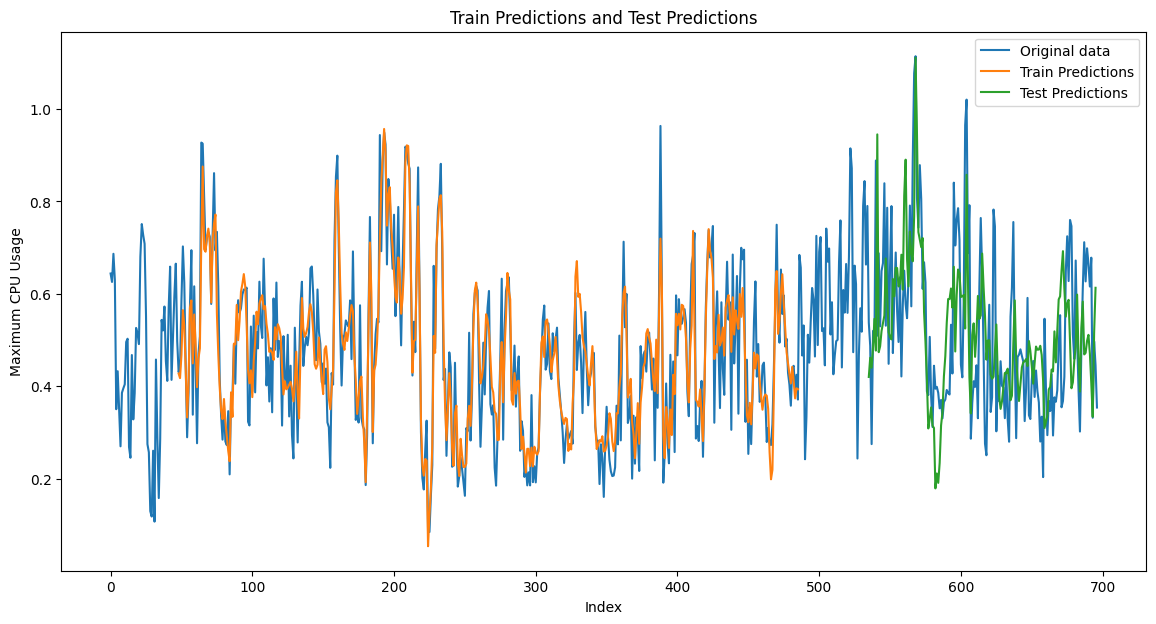

In [5]:
import matplotlib.pyplot as plt  

# Create empty arrays of NaNs  
train_predictions = np.empty_like(data)  
train_predictions[:] = np.nan  
test_predictions = np.empty_like(data)  
test_predictions[:] = np.nan  
  
# Generate predictions  
lstm.eval()  
with torch.no_grad():  
    for i, ((seq_trend, seq_detrended), labels) in enumerate(train_inout_seq):   
        seq_trend = torch.FloatTensor(seq_trend).view(-1, seq_length_in, input_size).to(device)  
        seq_detrended = torch.FloatTensor(seq_detrended).view(-1, seq_length_in, input_size).to(device)  
        train_pred = lstm(seq_trend, seq_detrended)  
        train_predictions[i+seq_length_in : i+seq_length_in+seq_length_out] = train_pred.cpu().numpy().flatten()  
  
    for i, ((seq_trend, seq_detrended), labels) in enumerate(test_inout_seq):  
        seq_trend = torch.FloatTensor(seq_trend).view(-1, seq_length_in, input_size).to(device)  
        seq_detrended = torch.FloatTensor(seq_detrended).view(-1, seq_length_in, input_size).to(device)  
        test_pred = lstm(seq_trend, seq_detrended)  
        test_predictions[i+train_size+seq_length_in : i+train_size+seq_length_in+seq_length_out] = test_pred.cpu().numpy().flatten()  

train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))  
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))  
data = scaler.inverse_transform(data.reshape(-1, 1))  
  
# Plotting  
plt.figure(figsize=(14, 7))  
  
# Original data  
plt.plot(range(len(data)), data, label='Original data')  
  
# Train predictions  
plt.plot(range(len(data)), train_predictions, label='Train Predictions')  
  
# Test predictions  
plt.plot(range(len(data)), test_predictions, label='Test Predictions')  
  
plt.title('Train Predictions and Test Predictions')  
plt.xlabel('Index')  
plt.ylabel('Maximum CPU Usage')  
plt.legend()  
plt.show()  
